# 📊 EDA y Análisis de Multicolinealidad

**Objetivo**: Analizar el dataset, detectar variables altamente correlacionadas y decidir cuáles eliminar para evitar problemas de atribución en el modelo MMM.

## Problema a resolver

Variables como `impressions_META` y `clicks_META` están altamente correlacionadas (ρ > 0.96). Si ambas entran al modelo, el efecto del canal se "reparte" entre sus coeficientes, rompiendo las curvas de respuesta.

**Solución**: Mantener solo una variable por canal (priorizamos `impressions`).


## 1. Configuración e Instalación


In [1]:
# Instalación de dependencias
!pip -q install rapidfuzz statsmodels scipy scikit-learn matplotlib seaborn pandas openpyxl


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✓ Librerías cargadas correctamente")


✓ Librerías cargadas correctamente


## 2. Carga de Datos

**Nota**: Este notebook asume que ya tienes el dataset consolidado `df_out` del notebook original. 

Si necesitas generar `df_out` desde cero, ejecuta las celdas de consolidación del notebook original (cells 6-75) o carga un CSV pre-procesado.


In [3]:
# Cargar dataset consolidado
# Este CSV se genera ejecutando el notebook original hasta la celda de exportación

import os

if not os.path.exists("dataset_consolidado_completo.csv"):
    print("❌ ERROR: No se encontró 'dataset_consolidado_completo.csv'")
    print("\n📋 SOLUCIÓN:")
    print("   1. Abre el notebook 'Proyecto_Final_Version_Mati_CtrlAds.ipynb'")
    print("   2. Ejecuta todas las celdas hasta encontrar la sección:")
    print("      '🔄 EXPORTAR df_out para notebooks limpios'")
    print("   3. Ejecuta esa celda para generar el CSV")
    print("   4. Vuelve a ejecutar este notebook")
    raise FileNotFoundError("Falta dataset_consolidado_completo.csv")

# Cargar dataset
df_out = pd.read_csv("dataset_consolidado_completo.csv")

print(f"✅ Dataset consolidado cargado exitosamente!")
print(f"   Shape: {df_out.shape}")
print(f"   Empresas: {df_out['empresa'].nunique()}")
print(f"   Período: {df_out['anio_iso'].min()}-{df_out['anio_iso'].max()}")
print(f"\n📊 Columnas disponibles: {len(df_out.columns)}")
print(f"   Primeras columnas: {df_out.columns[:10].tolist()}")


✅ Dataset consolidado cargado exitosamente!
   Shape: (2124, 64)
   Empresas: 22
   Período: 2023-2025

📊 Columnas disponibles: 64
   Primeras columnas: ['empresa', 'anio_iso', 'semana_iso', 'invest_GADS', 'invest_META', 'impressions_GADS', 'impressions_META', 'clicks_GADS', 'clicks_META', 'conversions_GADS']


## 3. Análisis de Correlación

Identificamos pares de variables con correlación muy alta (|ρ| > 0.90), especialmente entre:
- `impressions_META` y `clicks_META`
- `impressions_GADS` y `clicks_GADS`
- Otras métricas derivadas del mismo canal


In [4]:
# Configuración del análisis
TARGET = "transactions_GA"
ID_COLS = ["empresa", "anio_iso", "semana_iso", "Fecha", "periodo_m", "week_start"]

# Seleccionar columnas numéricas (excluyendo IDs y target)
num_cols = df_out.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ID_COLS and c != TARGET]

print(f"📊 Analizando {len(num_cols)} variables numéricas")
print(f"🎯 Variable objetivo: {TARGET}")
print(f"\nPrimeras variables: {num_cols[:10]}")


📊 Analizando 54 variables numéricas
🎯 Variable objetivo: transactions_GA

Primeras variables: ['invest_GADS', 'invest_META', 'impressions_GADS', 'impressions_META', 'clicks_GADS', 'clicks_META', 'conversions_GADS', 'conversions_META', 'revenue_GADS', 'revenue_META']


In [5]:
def corr_pairs(df, cols, method="spearman", thresh=0.90):
    """Encuentra pares de variables con alta correlación"""
    C = df[cols].corr(method=method)
    pairs = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            v = C.iloc[i, j]
            if np.isfinite(v) and abs(v) >= thresh:
                pairs.append((cols[i], cols[j], float(v)))
    pairs.sort(key=lambda x: -abs(x[2]))
    return C, pairs

# Correlación de Spearman (captura relaciones monotónicas)
C_spearman, pairs_spearman = corr_pairs(
    df_out.dropna(subset=[TARGET]), 
    num_cols, 
    method="spearman", 
    thresh=0.90
)

print(f"\n🔍 Encontrados {len(pairs_spearman)} pares con |ρ(Spearman)| >= 0.90\n")
print("Top 20 pares más correlacionados:\n")
for a, b, r in pairs_spearman[:20]:
    print(f"{a:35s} ~ {b:35s} | ρ = {r:+.4f}")



🔍 Encontrados 15 pares con |ρ(Spearman)| >= 0.90

Top 20 pares más correlacionados:

conversions_GADS                    ~ transactions_GADS                   | ρ = +1.0000
conversions_META                    ~ transactions_META                   | ρ = +1.0000
IPC General Acumulado               ~ Total índice de salarios            | ρ = +1.0000
sessions_GA                         ~ reach_GA                            | ρ = +0.9988
ticket_est_m                        ~ ticket_usd                          | ρ = +0.9643
impressions_META                    ~ clicks_META                         | ρ = +0.9635
Tasa de desocupación abierta        ~ Tasa de empleo                      | ρ = -0.9595
invest_META                         ~ invest_total_paid                   | ρ = +0.9526
impressions_GADS                    ~ clicks_GADS                         | ρ = +0.9487
sessions_GA                         ~ user_engagement_duration_GA         | ρ = +0.9297
reach_GA                          

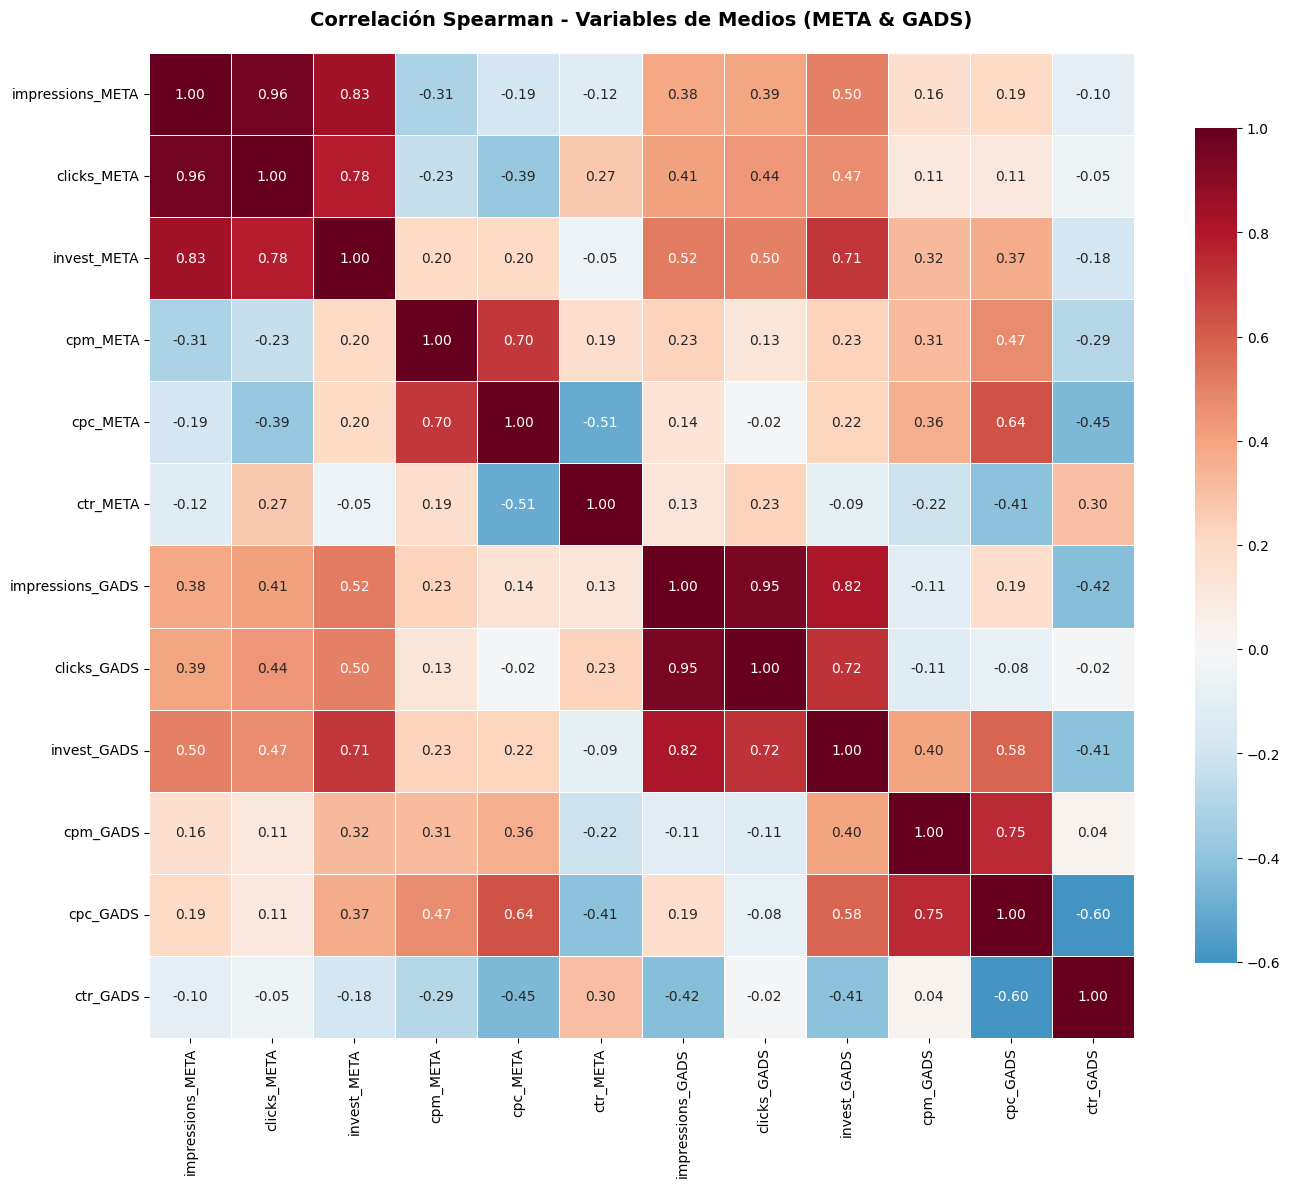


⚠️ OBSERVACIONES:
  • impressions y clicks tienen correlación muy alta (>0.95)
  • CPM, CPC, CTR son derivados matemáticos → también correlacionados
  • Solución: Mantener solo impressions por canal


In [6]:
# Visualizar correlaciones de variables clave de medios
key_media_vars = [
    "impressions_META", "clicks_META", "invest_META", "cpm_META", "cpc_META", "ctr_META",
    "impressions_GADS", "clicks_GADS", "invest_GADS", "cpm_GADS", "cpc_GADS", "ctr_GADS",
]
# Filtrar solo las que existen
key_media_vars = [v for v in key_media_vars if v in df_out.columns]

if len(key_media_vars) > 0:
    plt.figure(figsize=(14, 12))
    corr_media = df_out[key_media_vars].corr(method="spearman")
    
    sns.heatmap(
        corr_media,
        annot=True, fmt=".2f", cmap="RdBu_r", center=0,
        square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}
    )
    plt.title("Correlación Spearman - Variables de Medios (META & GADS)", 
              fontsize=14, weight="bold", pad=20)
    plt.tight_layout()
    plt.show()
    
    print("\n⚠️ OBSERVACIONES:")
    print("  • impressions y clicks tienen correlación muy alta (>0.95)")
    print("  • CPM, CPC, CTR son derivados matemáticos → también correlacionados")
    print("  • Solución: Mantener solo impressions por canal")


## 4. Cálculo de VIF (Variance Inflation Factor)

El VIF mide la multicolinealidad. Un VIF alto indica que una variable puede ser predicha por otras variables del modelo.

**Interpretación**:
- VIF < 5: Multicolinealidad baja (aceptable)
- VIF 5-10: Multicolinealidad moderada (revisar)
- VIF > 10: Multicolinealidad severa (eliminar o transformar)


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(df, cols):
    """Calcula VIF para cada columna"""
    # Filtrar columnas válidas (sin varianza cero, suficientes datos)
    valid_cols = []
    for c in cols:
        series = df[c]
        if series.std() > 1e-10 and series.notna().sum() > 10:
            valid_cols.append(c)
    
    if len(valid_cols) == 0:
        print("⚠️ No hay columnas válidas para calcular VIF")
        return pd.DataFrame()
    
    # Crear matriz X sin NaNs
    X = df[valid_cols].dropna()
    
    if len(X) < 10:
        print(f"⚠️ Muy pocas filas ({len(X)}) para calcular VIF")
        return pd.DataFrame()
    
    print(f"Calculando VIF para {len(X.columns)} variables...")
    
    vifs = []
    for i in range(len(X.columns)):
        try:
            vif = variance_inflation_factor(X.values, i)
            vifs.append((X.columns[i], float(vif)))
        except Exception as e:
            print(f"  ⚠️ VIF falló para {X.columns[i]}: {str(e)[:50]}")
            vifs.append((X.columns[i], np.nan))
    
    df_vif = pd.DataFrame(vifs, columns=["variable", "VIF"])
    df_vif = df_vif.sort_values("VIF", ascending=False).reset_index(drop=True)
    return df_vif

# Calcular VIF
print("Calculando VIF (puede tomar 1-2 minutos)...\\n")
vif_df = compute_vif(df_out, num_cols)

if len(vif_df) > 0:
    print("\\n📊 VIF de las variables (Top 30):\\n")
    print(vif_df.head(30).to_string(index=False))
    
    # Estadísticas
    high_vif = vif_df[vif_df["VIF"] > 10].dropna()
    moderate_vif = vif_df[(vif_df["VIF"] >= 5) & (vif_df["VIF"] <= 10)].dropna()
    
    print(f"\\n📈 RESUMEN VIF:")
    print(f"  • Variables con VIF > 10 (severo): {len(high_vif)}")
    print(f"  • Variables con VIF 5-10 (moderado): {len(moderate_vif)}")
    print(f"  • VIF mediano: {vif_df['VIF'].median():.2f}")
    print(f"  • VIF máximo: {vif_df['VIF'].max():.2f}")


Calculando VIF (puede tomar 1-2 minutos)...\n
Calculando VIF para 54 variables...
\n📊 VIF de las variables (Top 30):\n
                                       variable          VIF
                                    invest_GADS          inf
                                    invest_META          inf
                              transactions_META          inf
                              transactions_GADS          inf
                               conversions_META          inf
                               conversions_GADS          inf
                              invest_total_paid          inf
                          IPC General Acumulado 9.444602e+05
                                   Salario real 9.143596e+05
                       Total índice de salarios 9.075869e+05
                                 Tasa de empleo 3.843083e+05
Índice Estimador Mensual de Actividad Económica 1.721052e+05
     Índice Ventas en Supermercados y Shoppings 1.158814e+05
                           

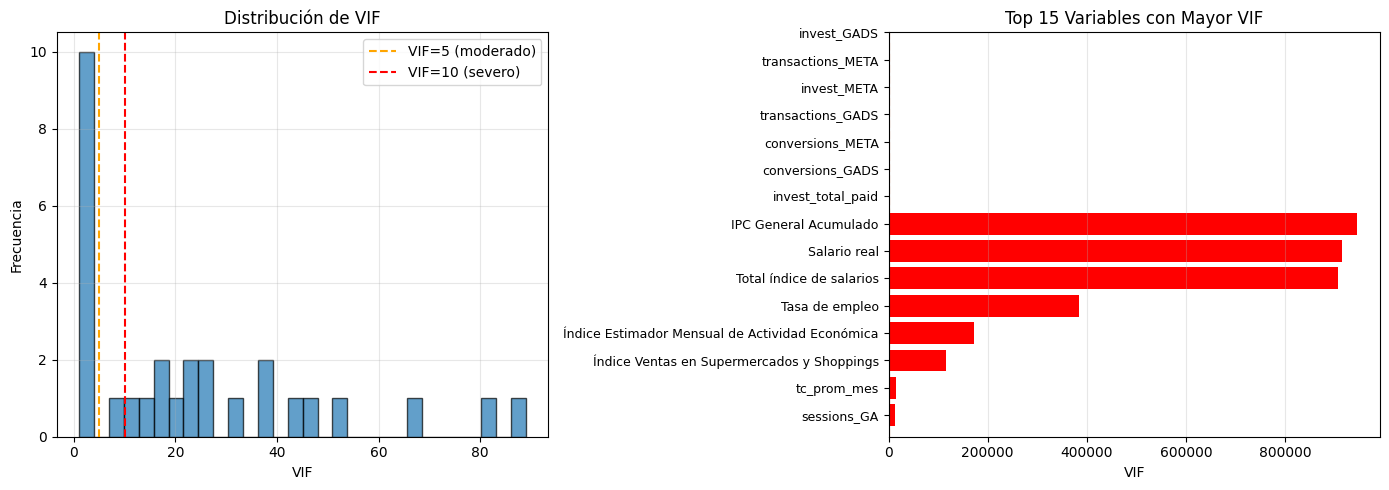

In [8]:
# Visualizar distribución de VIF
if len(vif_df) > 0 and vif_df['VIF'].notna().sum() > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histograma
    vif_finite = vif_df[vif_df['VIF'] < 100]['VIF']  # Excluir outliers extremos para visualización
    ax1.hist(vif_finite, bins=30, edgecolor='black', alpha=0.7)
    ax1.axvline(5, color='orange', linestyle='--', label='VIF=5 (moderado)')
    ax1.axvline(10, color='red', linestyle='--', label='VIF=10 (severo)')
    ax1.set_xlabel('VIF')
    ax1.set_ylabel('Frecuencia')
    ax1.set_title('Distribución de VIF')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Top variables con VIF alto
    top_vif = vif_df.head(15).sort_values('VIF')
    ax2.barh(range(len(top_vif)), top_vif['VIF'], color=['red' if v > 10 else 'orange' if v > 5 else 'green' for v in top_vif['VIF']])
    ax2.set_yticks(range(len(top_vif)))
    ax2.set_yticklabels(top_vif['variable'], fontsize=9)
    ax2.set_xlabel('VIF')
    ax2.set_title('Top 15 Variables con Mayor VIF')
    ax2.axvline(10, color='red', linestyle='--', alpha=0.5)
    ax2.axvline(5, color='orange', linestyle='--', alpha=0.5)
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()


## 5. Decisión: Variables a Eliminar

Basándonos en correlaciones y VIF, definimos una estrategia para eliminar variables redundantes:

**Reglas**:
1. Para cada par con ρ > 0.90, mantener la variable "preferida" (más interpretable)
2. Priorizar **impressions** sobre clicks (más fundamental)
3. Eliminar variables derivadas (CPM, CPC, CTR) si ya tenemos impressions/invest
4. Mantener solo una variable de conversión por canal (transactions o conversions, no ambas)


In [9]:
# Variables a preferir (mantener en caso de empate)
PREFER = [
    # Variables de medios (SOLO impressions)
    "impressions_META",
    "impressions_GADS",
    # Variables macro
    "Variación IPC (%) General",
    "Índice de Confianza del Consumidor",
    "IPC Prendas de vestir y calzado",
    # Info de cliente (mantener para optimización, pero NO usar en modelo)
    "Ticket_promedio_num",
    "ticket_est_m",
    "Margen_pct",
    "Costo_fijo_num",
]

# ⚠️ Variables auxiliares para OPTIMIZACIÓN (NO usar en modelo MMM)
# Estas variables se mantienen en el dataset limpio para el algoritmo de optimización,
# pero NO deben usarse como features en el modelo de regresión
AUX_VARS_FOR_OPTIMIZATION = [
    "invest_META",     # Para calcular ROI y conversión gasto -> impressions
    "invest_GADS",     # Para calcular ROI y conversión gasto -> impressions
    "cpm_META",        # Para calcular marginal return por dólar
    "cpm_GADS",        # Para calcular marginal return por dólar
    "ticket_usd",      # Para calcular profit
]

# Variables que FORZOSAMENTE debemos eliminar del modelo (métricas derivadas)
# Estas rompen la atribución porque son matemáticamente dependientes de impressions
FORCE_DROP_FROM_MODEL = [
    # Métricas derivadas META (correlacionadas con impressions)
    "cpc_META",  # = invest_META / clicks_META
    "ctr_META",  # = clicks_META / impressions_META
    # Métricas derivadas GADS
    "cpc_GADS",
    "ctr_GADS",
    # Clicks (correlacionados con impressions)
    "clicks_META",
    "clicks_GADS",
    # Conversions (usar solo transactions)
    "conversions_META",
    "conversions_GADS",
    # Funnel web (mediadores del efecto de medios sobre transacciones)
    # Estas variables capturan el efecto indirecto de impressions -> sessions -> transactions
    # Al eliminarlas, los betas de impressions capturarán el efecto total (directo + indirecto)
    "sessions_GA",
    "add_to_carts_GA",
    "checkouts_GA",
    "reach_GA",
    "user_engagement_duration_GA",
]

def drop_redundant_by_pairs(cols, high_pairs, prefer=None, force_drop=None, aux_vars=None):
    """Decide qué variables eliminar basándose en pares correlacionados
    
    Args:
        aux_vars: Variables auxiliares que se mantienen en dataset pero NO en modelo
    """
    prefer = set(prefer or [])
    force_drop = set(force_drop or [])
    aux_vars = set(aux_vars or [])
    
    drop_from_model = set()  # Variables a NO usar en modelo
    keep_for_model = set(cols)  # Variables OK para modelo
    keep_in_dataset = set(cols)  # Variables en dataset (modelo + aux)
    
    # Primero: marcar forzosamente las métricas derivadas como NO MODELO
    for var in force_drop:
        if var in keep_for_model:
            drop_from_model.add(var)
            keep_for_model.discard(var)
            keep_in_dataset.discard(var)  # Eliminar completamente
    
    # Segundo: Procesar pares correlacionados, PERO proteger variables auxiliares
    for a, b, r in high_pairs:
        # Si alguna de las dos es auxiliar, PROTEGERLA (no eliminar del dataset)
        if a in aux_vars:
            # a es auxiliar -> marcar como NO MODELO pero mantener en dataset
            drop_from_model.add(a)
            keep_for_model.discard(a)
            # keep_in_dataset NO cambia (se mantiene)
            continue
        
        if b in aux_vars:
            # b es auxiliar -> marcar como NO MODELO pero mantener en dataset
            drop_from_model.add(b)
            keep_for_model.discard(b)
            # keep_in_dataset NO cambia (se mantiene)
            continue
        
        # Si ya fue procesada, saltar
        if a in drop_from_model or b in drop_from_model:
            continue
        
        # Si ambos son preferidos, mantener ambos (Ridge manejará la regularización)
        if a in prefer and b in prefer:
            continue
        
        # Si uno es preferido, eliminar el otro
        if a in prefer and b not in prefer:
            drop_from_model.add(b)
            keep_for_model.discard(b)
            keep_in_dataset.discard(b)
        elif b in prefer and a not in prefer:
            drop_from_model.add(a)
            keep_for_model.discard(a)
            keep_in_dataset.discard(a)
        else:
            # Si ninguno es preferido, eliminar el segundo (convención arbitraria)
            drop_from_model.add(b)
            keep_for_model.discard(b)
            keep_in_dataset.discard(b)
    
    # Tercero: Marcar variables auxiliares como NO MODELO (pero mantener en dataset)
    for var in aux_vars:
        if var in keep_for_model:
            drop_from_model.add(var)
            keep_for_model.discard(var)
            # keep_in_dataset NO cambia (se mantiene)
    
    return sorted(keep_for_model), sorted(drop_from_model), sorted(keep_in_dataset)

# Aplicar lógica de eliminación
keep_vars, drop_vars, keep_in_dataset = drop_redundant_by_pairs(
    num_cols, 
    pairs_spearman, 
    prefer=PREFER,
    force_drop=FORCE_DROP_FROM_MODEL,
    aux_vars=AUX_VARS_FOR_OPTIMIZATION
)

# Variables auxiliares = en dataset pero NO en modelo
aux_vars_kept = sorted(set(keep_in_dataset) - set(keep_vars))

print(f"\n✅ VARIABLES PARA EL MODELO MMM: {len(keep_vars)}")
print("\nPrincipales variables mantenidas:")
for v in [v for v in PREFER if v in keep_vars][:15]:
    print(f"  • {v}")

print(f"\n🔧 VARIABLES AUXILIARES (en dataset, NO en modelo): {len(aux_vars_kept)}")
for v in aux_vars_kept:
    print(f"  • {v} → Para optimización de presupuesto")

print(f"\n❌ VARIABLES ELIMINADAS DEL MODELO: {len(drop_vars)}")
print(f"\n   🔥 FORZOSAMENTE ELIMINADAS: {len([v for v in FORCE_DROP_FROM_MODEL if v in drop_vars])}")
print("      (Incluye métricas derivadas + variables del funnel web)")
for v in [v for v in FORCE_DROP_FROM_MODEL if v in drop_vars]:
    print(f"      • {v}")
print("\n   📊 Otras variables eliminadas por correlación:")
for v in [v for v in drop_vars if v not in FORCE_DROP_FROM_MODEL and v not in aux_vars_kept][:15]:
    print(f"      • {v}")

# Verificar eliminación del funnel web
web_funnel_vars = ["sessions_GA", "add_to_carts_GA", "checkouts_GA", "reach_GA", "user_engagement_duration_GA"]
print(f"\n🔍 VERIFICACIÓN - Variables del Funnel Web:")
for var in web_funnel_vars:
    if var in drop_vars:
        print(f"  ✓ {var}: ELIMINADA (permite capturar efecto total de impressions)")
    elif var in keep_vars:
        print(f"  ✗ {var}: MANTENIDA (¡revisar!)")
    else:
        print(f"  ? {var}: No encontrada en dataset")



✅ VARIABLES PARA EL MODELO MMM: 32

Principales variables mantenidas:
  • impressions_META
  • impressions_GADS
  • Variación IPC (%) General
  • Índice de Confianza del Consumidor
  • IPC Prendas de vestir y calzado
  • Ticket_promedio_num
  • ticket_est_m
  • Margen_pct
  • Costo_fijo_num

🔧 VARIABLES AUXILIARES (en dataset, NO en modelo): 5
  • cpm_GADS → Para optimización de presupuesto
  • cpm_META → Para optimización de presupuesto
  • invest_GADS → Para optimización de presupuesto
  • invest_META → Para optimización de presupuesto
  • ticket_usd → Para optimización de presupuesto

❌ VARIABLES ELIMINADAS DEL MODELO: 22

   🔥 FORZOSAMENTE ELIMINADAS: 13
      (Incluye métricas derivadas + variables del funnel web)
      • cpc_META
      • ctr_META
      • cpc_GADS
      • ctr_GADS
      • clicks_META
      • clicks_GADS
      • conversions_META
      • conversions_GADS
      • sessions_GA
      • add_to_carts_GA
      • checkouts_GA
      • reach_GA
      • user_engagement_durati

In [10]:
# Verificar que clicks_* fueron eliminados
clicks_in_drop = [v for v in drop_vars if 'clicks' in v.lower()]
clicks_in_keep = [v for v in keep_vars if 'clicks' in v.lower()]

print("\\n🔍 VERIFICACIÓN - Variables 'clicks':")
print(f"  • En lista de eliminar: {len(clicks_in_drop)} → {clicks_in_drop}")
print(f"  • En lista de mantener: {len(clicks_in_keep)} → {clicks_in_keep}")

if len(clicks_in_keep) == 0:
    print("\\n✅ CONFIRMADO: Todas las variables 'clicks' serán eliminadas")
else:
    print("\\n⚠️ ADVERTENCIA: Algunas variables 'clicks' se mantendrán")

# También verificar otras métricas derivadas problemáticas
derived_metrics = ['cpm', 'cpc', 'ctr', 'cpa', 'roas']
for metric in derived_metrics:
    metric_in_drop = [v for v in drop_vars if metric in v.lower()]
    if len(metric_in_drop) > 0:
        print(f"  • {metric.upper()}: {len(metric_in_drop)} variables eliminadas")


\n🔍 VERIFICACIÓN - Variables 'clicks':
  • En lista de eliminar: 2 → ['clicks_GADS', 'clicks_META']
  • En lista de mantener: 0 → []
\n✅ CONFIRMADO: Todas las variables 'clicks' serán eliminadas
  • CPM: 2 variables eliminadas
  • CPC: 2 variables eliminadas
  • CTR: 2 variables eliminadas


In [11]:
# Crear dataset limpio manteniendo:
# 1. Variables para el modelo (keep_vars)
# 2. Variables auxiliares para optimización (aux_vars_kept)
# NOTA: aux_vars NO deben usarse como features en el modelo MMM

# Variables que van al dataset limpio
all_vars_for_dataset = list(set(keep_in_dataset))  # Usar keep_in_dataset directamente
keep_cols = ID_COLS + all_vars_for_dataset + [TARGET]
keep_cols = [c for c in keep_cols if c in df_out.columns]  # Asegurar que existan
keep_cols = list(dict.fromkeys(keep_cols))  # Eliminar duplicados manteniendo orden

df_clean = df_out[keep_cols].copy()

print(f"✓ Dataset limpio creado")
print(f"  Filas: {len(df_clean):,}")
print(f"  Columnas totales: {len(df_clean.columns)}")
print(f"  Variables para MODELO: {len(keep_vars)}")
print(f"  Variables AUXILIARES (optimización): {len(aux_vars_kept)}")
print(f"  Variables eliminadas: {len([v for v in num_cols if v not in keep_in_dataset])}")
print(f"\n📊 NOTA: Variables del funnel web eliminadas para capturar efecto total de medios")

# Resumen de nulos
null_pct = (df_clean.isnull().sum() / len(df_clean) * 100).sort_values(ascending=False)
print(f"\nColumnas con > 10% nulos:")
high_nulls = null_pct[null_pct > 10]
if len(high_nulls) > 0:
    print(high_nulls.head(10))
else:
    print("  (Ninguna)")


✓ Dataset limpio creado
  Filas: 2,124
  Columnas totales: 43
  Variables para MODELO: 32
  Variables AUXILIARES (optimización): 5
  Variables eliminadas: 17

📊 NOTA: Variables del funnel web eliminadas para capturar efecto total de medios

Columnas con > 10% nulos:
Margen_pct                      40.160075
Costo_fijo_num                  40.160075
cpm_META                        27.636535
invest_META                     26.836158
revenue_META                    26.836158
revenue_GADS                    23.634652
cpm_GADS                        23.634652
invest_GADS                     23.634652
Tasa de desocupación abierta    11.393597
dtype: float64


## 7. Recalcular VIF (Post-limpieza)

Verificamos que el VIF mejoró significativamente tras eliminar variables redundantes.


In [12]:
# Recalcular VIF en dataset limpio
num_cols_clean = [c for c in keep_vars if c in df_clean.columns]

print("Recalculando VIF en dataset limpio...\\n")
vif_df_clean = compute_vif(df_clean, num_cols_clean)

if len(vif_df_clean) > 0:
    print("\\n📊 VIF POST-LIMPIEZA (Top 20):\\n")
    print(vif_df_clean.head(20).to_string(index=False))
    
    # Comparación antes/después
    high_vif_before = len(vif_df[vif_df["VIF"] > 10].dropna()) if len(vif_df) > 0 else 0
    high_vif_after = len(vif_df_clean[vif_df_clean["VIF"] > 10].dropna())
    
    print(f"\\n📊 COMPARACIÓN VIF:")
    print(f"  Variables con VIF > 10:")
    print(f"    • Antes:   {high_vif_before}")
    print(f"    • Después: {high_vif_after}")
    print(f"    • Mejora:  {high_vif_before - high_vif_after} variables")
    
    if high_vif_after > 0:
        print(f"\\n  ⚠️ Aún hay {high_vif_after} variables con VIF > 10:")
        print(vif_df_clean[vif_df_clean["VIF"] > 10].to_string(index=False))
    else:
        print("\\n  ✅ No quedan variables con VIF > 10")
    
    # Check media variables specifically
    print(f"\\n🎯 VIF DE VARIABLES DE MEDIOS (objetivo principal):")
    media_vars = ["impressions_META", "impressions_GADS"]
    for var in media_vars:
        if var in vif_df_clean["variable"].values:
            vif_val = vif_df_clean[vif_df_clean["variable"] == var]["VIF"].values[0]
            status = "✅" if vif_val < 10 else "⚠️" if vif_val < 15 else "❌"
            print(f"  {status} {var}: VIF = {vif_val:.2f}")
    
    print("\\n💡 INTERPRETACIÓN:")
    print("  Al eliminar variables del funnel web (sessions_GA, add_to_carts_GA, etc.),")
    print("  los coeficientes de impressions_META e impressions_GADS ahora capturarán")
    print("  el efecto TOTAL (directo + indirecto) sobre las transacciones.")


Recalculando VIF en dataset limpio...\n
Calculando VIF para 32 variables...
\n📊 VIF POST-LIMPIEZA (Top 20):\n
                                          variable          VIF
        Índice Ventas en Supermercados y Shoppings 36558.350642
   Índice Estimador Mensual de Actividad Económica 28669.069488
                                      Salario real 16306.766824
                Índice de Confianza del Consumidor  3988.105405
                                       tc_prom_mes  1424.861366
                               Ticket_promedio_num  1422.181046
                                      ticket_est_m  1259.692481
                      Tasa de desocupación abierta  1058.623929
                              Brecha Cambiaria (%)    68.591925
                                        Margen_pct    55.091165
                     average_sessions_durations_GA    45.954498
                   IPC Prendas de vestir y calzado    25.202009
                                 invest_total_paid    18.2

## 8. Exportar Resultados


In [13]:
# Guardar dataset limpio
df_clean.to_csv("dataset_limpio_sin_multicolinealidad.csv", index=False)
print("✓ Dataset guardado: 'dataset_limpio_sin_multicolinealidad.csv'")

# Guardar lista de variables eliminadas
pd.DataFrame({
    "variable_eliminada": drop_vars,
    "razon": "Alta correlación con variable preferida (ρ > 0.90)"
}).to_csv("variables_eliminadas.csv", index=False)
print("✓ Registro guardado: 'variables_eliminadas.csv'")

# Guardar análisis de VIF
if len(vif_df_clean) > 0:
    vif_df_clean.to_csv("vif_post_limpieza.csv", index=False)
    print("✓ VIF guardado: 'vif_post_limpieza.csv'")

# Guardar matriz de correlación
if len(pairs_spearman) > 0:
    pd.DataFrame(pairs_spearman, columns=["variable_1", "variable_2", "correlacion"]).to_csv(
        "pares_alta_correlacion.csv", index=False
    )
    print("✓ Pares correlacionados guardados: 'pares_alta_correlacion.csv'")

# Exportar lista de features para el modelo (sin variables auxiliares)
pd.DataFrame({
    "variable": keep_vars,
    "tipo": ["modelo" if v not in aux_vars_kept else "auxiliar" for v in keep_vars]
}).to_csv("modelo_features.csv", index=False)
print("✓ Features del modelo guardadas: 'modelo_features.csv'")

# Exportar lista de variables auxiliares
if len(aux_vars_kept) > 0:
    pd.DataFrame({
        "variable": aux_vars_kept,
        "uso": "optimizacion",
        "nota": "NO usar como feature en modelo MMM"
    }).to_csv("variables_auxiliares_optimizacion.csv", index=False)
    print("✓ Variables auxiliares guardadas: 'variables_auxiliares_optimizacion.csv'")


✓ Dataset guardado: 'dataset_limpio_sin_multicolinealidad.csv'
✓ Registro guardado: 'variables_eliminadas.csv'
✓ VIF guardado: 'vif_post_limpieza.csv'
✓ Pares correlacionados guardados: 'pares_alta_correlacion.csv'
✓ Features del modelo guardadas: 'modelo_features.csv'
✓ Variables auxiliares guardadas: 'variables_auxiliares_optimizacion.csv'


## 9. Resumen Ejecutivo


In [14]:
print("="*80)
print("            RESUMEN: LIMPIEZA DE MULTICOLINEALIDAD")
print("="*80)
print(f"\\n📊 VARIABLES:")
print(f"  • Originales:         {len(num_cols)}")
print(f"  • Eliminadas:         {len(drop_vars)}")
print(f"  • Finales (modelo):   {len(keep_vars)}")

print(f"\\n🔍 CORRELACIONES:")
print(f"  • Pares con ρ > 0.90: {len(pairs_spearman)}")

print(f"\\n📈 VIF:")
if len(vif_df) > 0 and len(vif_df_clean) > 0:
    print(f"  • Antes: {len(vif_df[vif_df['VIF'] > 10])} variables con VIF > 10")
    print(f"  • Después: {len(vif_df_clean[vif_df_clean['VIF'] > 10])} variables con VIF > 10")

print(f"\\n❌ PRINCIPALES ELIMINACIONES:")
key_eliminations = [
    ("clicks_META/GADS", "Alta correlación con impressions"),
    ("cpm_META/GADS", "Métrica derivada"),
    ("cpc_META/GADS", "Métrica derivada"),
    ("ctr_META/GADS", "Métrica derivada"),
    ("sessions_GA", "Mediador del efecto de impressions"),
    ("add_to_carts_GA", "Mediador del efecto de impressions"),
    ("checkouts_GA", "Mediador del efecto de impressions"),
    ("reach_GA", "Alta correlación con sessions_GA"),
    ("user_engagement_duration_GA", "Alta correlación con sessions_GA"),
]
for var, reason in key_eliminations:
    vars_matched = [v for v in drop_vars if var.replace("/", "").replace("_META", "").replace("_GADS", "").lower() in v.lower()]
    if len(vars_matched) > 0:
        print(f"  • {var}: {reason}")

print(f"\\n✅ VARIABLES CLAVE MANTENIDAS:")
key_keeps = [
    "impressions_META  → Alcance META (captura efecto total sobre transacciones)",
    "impressions_GADS  → Alcance GADS (captura efecto total sobre transacciones)",
]
for item in key_keeps:
    print(f"  • {item}")

print(f"\\n⚡ CAMBIO IMPORTANTE:")
print("  Las variables del funnel web (sessions_GA, add_to_carts_GA, checkouts_GA)")
print("  fueron ELIMINADAS para evitar la división del efecto de los medios.")
print("  Ahora los betas de impressions capturarán el efecto COMPLETO:")
print("    • Efecto directo: impressions → transactions")
print("    • Efecto indirecto: impressions → sessions → transactions")

print(f"\\n🎯 PRÓXIMO PASO:")
print("  → Usar 'dataset_limpio_sin_multicolinealidad.csv' para entrenar el modelo MMM")
print("  → Las curvas de respuesta ahora asignarán correctamente el efecto de cada canal")
print("="*80)


            RESUMEN: LIMPIEZA DE MULTICOLINEALIDAD
\n📊 VARIABLES:
  • Originales:         54
  • Eliminadas:         22
  • Finales (modelo):   32
\n🔍 CORRELACIONES:
  • Pares con ρ > 0.90: 15
\n📈 VIF:
  • Antes: 42 variables con VIF > 10
  • Después: 18 variables con VIF > 10
\n❌ PRINCIPALES ELIMINACIONES:
  • sessions_GA: Mediador del efecto de impressions
  • add_to_carts_GA: Mediador del efecto de impressions
  • checkouts_GA: Mediador del efecto de impressions
  • reach_GA: Alta correlación con sessions_GA
  • user_engagement_duration_GA: Alta correlación con sessions_GA
\n✅ VARIABLES CLAVE MANTENIDAS:
  • impressions_META  → Alcance META (captura efecto total sobre transacciones)
  • impressions_GADS  → Alcance GADS (captura efecto total sobre transacciones)
\n⚡ CAMBIO IMPORTANTE:
  Las variables del funnel web (sessions_GA, add_to_carts_GA, checkouts_GA)
  fueron ELIMINADAS para evitar la división del efecto de los medios.
  Ahora los betas de impressions capturarán el efecto CO